In [1]:
import pyarrow.parquet as pq

table = pq.read_table(
    r"C:\Users\StrucData 1\Downloads\1-Neris-20110810.binetflow.parquet\1-Neris-20110810.binetflow.parquet",
    read_dictionary=False
)

df = table.to_pandas(ignore_metadata=True)
df.reset_index(drop=True, inplace=True)


In [2]:
import pandas as pd
import numpy as np
import pyarrow as pa

print(f"Pandas version: {pd.__version__}")
print(f"NumPy version:  {np.__version__}")
print(f"PyArrow version: {pa.__version__}")

# This check provides a deeper look at your environment's health
pd.show_versions()

Pandas version: 2.1.4
NumPy version:  1.26.4
PyArrow version: 14.0.2


C:\Users\StrucData 1\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(



INSTALLED VERSIONS
------------------
commit              : a671b5a8bf5dd13fb19f0e88edc679bc9e15c673
python              : 3.11.0.final.0
python-bits         : 64
OS                  : Windows
OS-release          : 10
Version             : 10.0.26100
machine             : AMD64
processor           : Intel64 Family 6 Model 191 Stepping 2, GenuineIntel
byteorder           : little
LC_ALL              : None
LANG                : None
LOCALE              : English_India.1252

pandas              : 2.1.4
numpy               : 1.26.4
pytz                : 2025.2
dateutil            : 2.9.0.post0
setuptools          : 80.9.0
pip                 : 25.2
Cython              : None
pytest              : None
hypothesis          : None
sphinx              : None
blosc               : None
feather             : None
xlsxwriter          : None
lxml.etree          : None
html5lib            : None
pymysql             : None
psycopg2            : None
jinja2              : 3.1.6
IPython             

In [3]:
df_sample = df.sample(1000)
print(df_sample)



                 dur proto    dir      state  stos  dtos  tot_pkts  tot_bytes  \
1256306    17.325846   tcp     ->    FSA_FSA   0.0   0.0         6        372   
1449878    63.972248   tcp     ->  FSPA_FSPA   0.0   0.0        10       2235   
730704      0.000261   udp    <->        CON   0.0   0.0         2        360   
1120915  3045.185303   udp    <->        CON   0.0   0.0        16       2371   
923171   3583.477051   udp    <->        CON   0.0   0.0         4        678   
...              ...   ...    ...        ...   ...   ...       ...        ...   
1571630   643.901062   tcp     ->  SRPA_FSPA   0.0   0.0        49      11323   
181859    601.440430   udp    <->        CON   0.0   0.0         4        266   
960617   3571.292969   tcp     ->      PA_PA   0.0   0.0       483     171029   
435999   3205.833252   udp    <->        CON   0.0   0.0         8       1764   
1235434     0.007159   tcp     ->  FSPA_FSPA   0.0   0.0        16       6078   

         src_bytes         

In [4]:
import numpy as np

dur_bins = np.quantile(np.log10(df_sample['dur'] + 1e-6), [0.33, 0.66])
bytes_bins = np.quantile(np.log10(df_sample['tot_bytes'] + 1), [0.33, 0.66])
pkt_bins = np.quantile(df_sample['tot_pkts'], [0.33, 0.66])

In [5]:
def bucketize(x, bins, log=False):
    if log:
        x = np.log10(x + 1e-6)
    if x <= bins[0]:
        return "low"
    elif x <= bins[1]:
        return "mid"
    else:
        return "high"


In [6]:
df_sample['dur_bucket'] = df_sample['dur'].apply(
    lambda x: bucketize(x, dur_bins, log=True)
)

df_sample['bytes_bucket'] = df_sample['tot_bytes'].apply(
    lambda x: bucketize(x, bytes_bins, log=True)
)

df_sample['pkt_bucket'] = df_sample['tot_pkts'].apply(
    lambda x: bucketize(x, pkt_bins)
)


In [7]:
print(df_sample.columns)


Index(['dur', 'proto', 'dir', 'state', 'stos', 'dtos', 'tot_pkts', 'tot_bytes',
       'src_bytes', 'label', 'Family', 'dur_bucket', 'bytes_bucket',
       'pkt_bucket'],
      dtype='object')


In [8]:
import networkx as nx
from collections import defaultdict

# -----------------------------
# Graph + external labels
# -----------------------------
G = nx.MultiDiGraph()
flow_labels = {}

# -----------------------------
# Co-occurrence counters
# -----------------------------
proto_state_cnt = defaultdict(int)
state_dur_cnt = defaultdict(int)
dur_vol_cnt = defaultdict(int)
pkt_byte_cnt = defaultdict(int)

# -----------------------------
# First pass: Flow-centric KG
# -----------------------------
for idx, row in df_sample.iterrows():
    flow = f"flow::{idx}"

    # ---------- Namespaced nodes ----------
    proto = f"proto::{row['proto']}"
    direction = f"dir::{row['dir']}"
    state = f"state::{row['state']}"
    dur = f"dur::{row['dur_bucket']}"
    pkt = f"pkt::{row['pkt_bucket']}"
    byte = f"byte::{row['bytes_bucket']}"
    family = f"family::{row['Family']}"

    # ---------- Nodes ----------
    G.add_node(flow, type="flow")
    G.add_node(proto, type="protocol")
    G.add_node(direction, type="direction")
    G.add_node(state, type="state")
    G.add_node(dur, type="duration_bucket")
    G.add_node(pkt, type="packet_bucket")
    G.add_node(byte, type="byte_bucket")
    G.add_node(family, type="family")

    # ---------- Structural (non-semantic) edges ----------
    G.add_edge(flow, proto,
               relation="USES_PROTOCOL",
               edge_type="structural")

    G.add_edge(flow, direction,
               relation="HAS_DIRECTION",
               edge_type="structural")

    G.add_edge(flow, state,
               relation="HAS_STATE",
               edge_type="structural")

    G.add_edge(flow, dur,
               relation="HAS_DURATION",
               edge_type="structural")

    G.add_edge(flow, pkt,
               relation="HAS_PKT_VOLUME",
               edge_type="structural")

    G.add_edge(flow, byte,
               relation="HAS_BYTE_VOLUME",
               edge_type="structural")

    G.add_edge(flow, family,
               relation="BELONGS_TO",
               edge_type="structural")

    # ---------- Count co-occurrences for semantic edges ----------
    proto_state_cnt[(proto, state)] += 1
    state_dur_cnt[(state, dur)] += 1
    dur_vol_cnt[(dur, byte)] += 1
    pkt_byte_cnt[(pkt, byte)] += 1

    # ---------- Store label externally ----------
    flow_labels[flow] = row["label"]

# -----------------------------
# Second pass: Semantic edges (EXPLICIT)
# -----------------------------
MIN_COUNT = 2  # correct for ~1k flows

# PROTOCOL → STATE
for (proto, state), c in proto_state_cnt.items():
    if c >= MIN_COUNT:
        G.add_edge(
            proto, state,
            relation="PROTO_STATE",
            edge_type="semantic",
            weight=c
        )

# STATE → DURATION
for (state, dur), c in state_dur_cnt.items():
    if c >= MIN_COUNT:
        G.add_edge(
            state, dur,
            relation="STATE_DURATION",
            edge_type="semantic",
            weight=c
        )

# DURATION → BYTE
for (dur, byte), c in dur_vol_cnt.items():
    if c >= MIN_COUNT:
        G.add_edge(
            dur, byte,
            relation="DURATION_VOLUME",
            edge_type="semantic",
            weight=c
        )

# PACKET → BYTE
for (pkt, byte), c in pkt_byte_cnt.items():
    if c >= MIN_COUNT:
        G.add_edge(
            pkt, byte,
            relation="PKT_BYTE_CORRELATION",
            edge_type="semantic",
            weight=c
        )


In [9]:
semantic_edges = [
    (u, v, d)
    for u, v, d in G.edges(data=True)
    if d.get("edge_type") == "semantic"
]


In [10]:
semantic_only = G.edge_subgraph([
    (u, v, k)
    for u, v, k, d in G.edges(keys=True, data=True)
    if d.get("edge_type") == "semantic"
])


In [11]:
from collections import Counter

Counter(
    d["relation"]
    for _, _, d in G.edges(data=True)
    if d.get("edge_type") == "semantic"
)


Counter({'STATE_DURATION': 33,
         'PROTO_STATE': 27,
         'DURATION_VOLUME': 9,
         'PKT_BYTE_CORRELATION': 8})

In [12]:
sorted(
    [(u, v, d["weight"]) for u, v, d in G.edges(data=True)
     if d.get("edge_type") == "semantic"],
    key=lambda x: x[2],
    reverse=True
)[:10]


[('proto::udp', 'state::CON', 678),
 ('state::CON', 'dur::high', 312),
 ('state::CON', 'dur::low', 278),
 ('pkt::high', 'byte::high', 275),
 ('pkt::low', 'byte::low', 210),
 ('pkt::mid', 'byte::mid', 174),
 ('dur::mid', 'byte::high', 157),
 ('dur::low', 'byte::low', 157),
 ('dur::high', 'byte::high', 141),
 ('proto::tcp', 'state::FSPA_FSPA', 136)]

In [13]:
# Check top weighted proto-state relations
import pandas as pd

proto_state_edges = [
    (u, v, d["weight"])
    for u, v, d in G.edges(data=True)
    if d["relation"] == "PROTO_STATE"
]

pd.DataFrame(
    proto_state_edges,
    columns=["proto", "state", "weight"]
).sort_values("weight", ascending=False).head(10)


,proto,state,weight
21,proto::udp,state::CON,678
1,proto::tcp,state::FSPA_FSPA,136
4,proto::tcp,state::SRPA_FSPA,27
5,proto::tcp,state::S_RA,26
22,proto::udp,state::INT,23
2,proto::tcp,state::S_,21
0,proto::tcp,state::FSA_FSA,20
7,proto::tcp,state::FSPA_FSRPA,7
14,proto::tcp,state::FSRPA_FSPA,5
8,proto::tcp,state::FSPA_FSA,5


In [14]:
#measure abstractio quality
num_flows = sum(1 for _, d in G.nodes(data=True) if d["type"] == "flow")
num_attrs = sum(1 for _, d in G.nodes(data=True) if d["type"] != "flow")

compression_ratio = num_flows / num_attrs
print(compression_ratio)


20.408163265306122


In [15]:
#calculate ARS
import numpy as np

attr_degrees = [
    G.degree(n)
    for n, d in G.nodes(data=True)
    if d["type"] != "flow"
]

ARS = np.mean(attr_degrees)
print(ARS)


146.0


In [16]:
#define semantic edges
semantic_edges = [
    d["weight"]
    for _, _, d in G.edges(data=True)
    if d.get("edge_type") == "semantic"
]
print(type(semantic_edges))
print(type(semantic_edges[0]))
print(semantic_edges[:10])



<class 'list'>
<class 'int'>
[20, 136, 21, 2, 27, 26, 2, 7, 5, 3]


In [17]:
#calculate SES
import numpy as np

SES = np.mean(semantic_edges)
SES


51.66233766233766

In [18]:
#calculate KG quality
from scipy.stats import entropy
import numpy as np

# semantic_edges MUST be a list of numbers (weights)
weights = np.array(semantic_edges)

# Normalize to probability distribution
weights = weights / weights.sum()

# Semantic Concentration
SC = 1 - entropy(weights)

KG_QUALITY = (
    0.25 * np.log1p(compression_ratio) +
    0.25 * np.log1p(ARS) +
    0.25 * np.log1p(SES) +
    0.25 * SC
)

KG_QUALITY



2.44813263306448

In [19]:
import networkx as nx

# Semantic-only graph
G_sem = nx.Graph()

for u, v, d in G.edges(data=True):
    if d.get("edge_type") == "semantic":
        G_sem.add_edge(u, v, weight=d["weight"])


In [20]:
#computing cosine similarity
from node2vec import Node2Vec

node2vec = Node2Vec(
    G_sem,
    dimensions=64,
    walk_length=20,
    num_walks=100,
    workers=4,
    weight_key="weight"
)

model = node2vec.fit(
    window=10,
    min_count=1,
    batch_words=4
)

import numpy as np

def cosine_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


positive_pairs = [
    (u, v)
    for u, v, d in G.edges(data=True)
    if d.get("relation") == "PROTO_STATE"
]


import random

nodes = list(G_sem.nodes())

negative_pairs = []
while len(negative_pairs) < len(positive_pairs):
    u, v = random.sample(nodes, 2)
    if not G_sem.has_edge(u, v):
        negative_pairs.append((u, v))


pos_sims = [
    cosine_sim(model.wv[u], model.wv[v])
    for u, v in positive_pairs
    if u in model.wv and v in model.wv
]

neg_sims = [
    cosine_sim(model.wv[u], model.wv[v])
    for u, v in negative_pairs
    if u in model.wv and v in model.wv
]







C:\Users\StrucData 1\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Computing transition probabilities: 100%|██████████| 39/39 [00:00<00:00, 18810.70it/s]


In [21]:
print("Positive cosine similarity:")
print("  mean =", np.mean(pos_sims))
print("  std  =", np.std(pos_sims))

print("\nNegative cosine similarity:")
print("  mean =", np.mean(neg_sims))
print("  std  =", np.std(neg_sims))


Positive cosine similarity:
  mean = 0.8107109
  std  = 0.09016967

Negative cosine similarity:
  mean = 0.5543571
  std  = 0.20246522


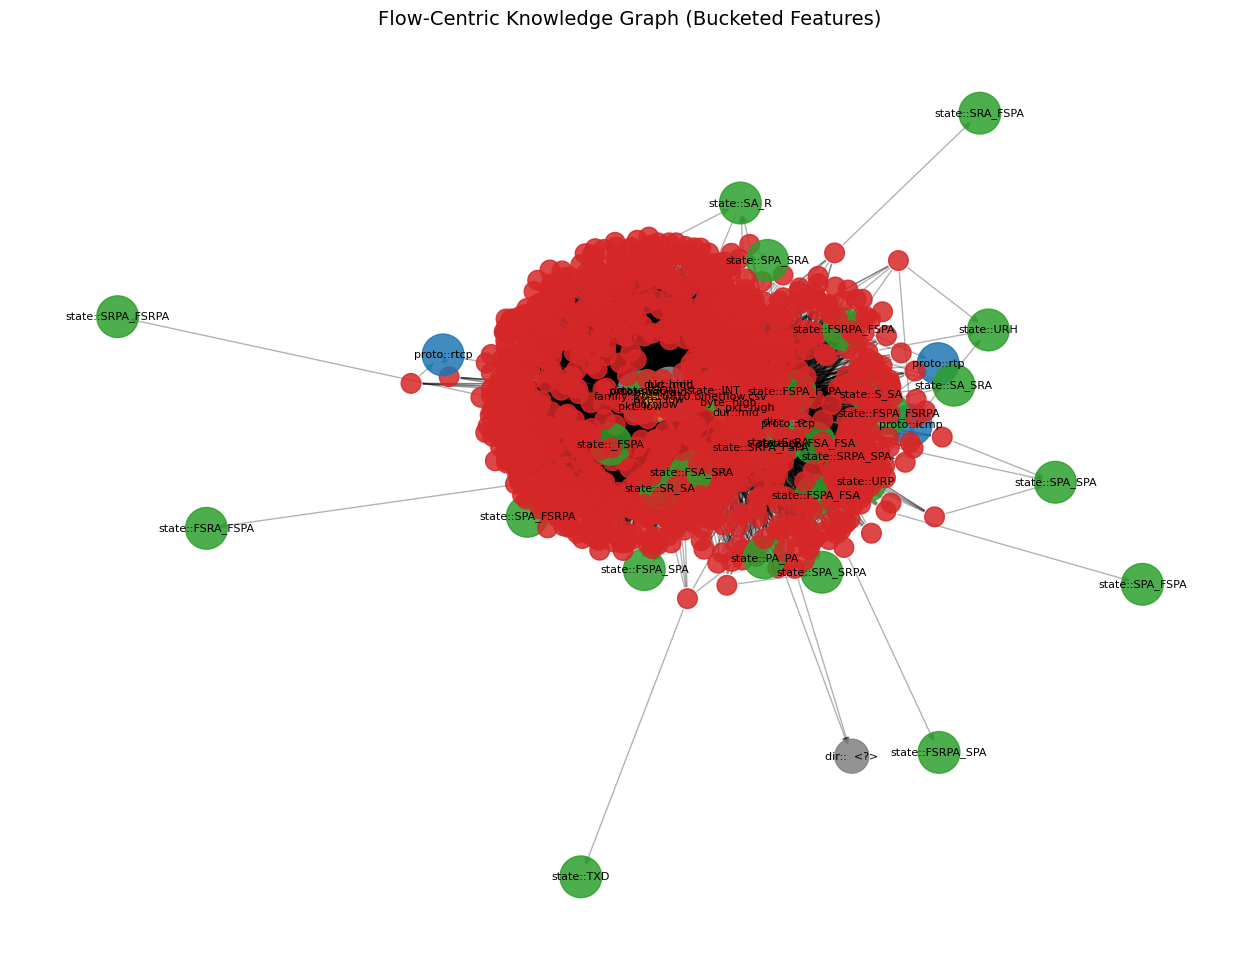

Nodes: 1049
Edges: 7077


In [22]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(16, 12))

pos = nx.spring_layout(G, k=0.9, seed=42)

# ---- Node styling by type ----
node_colors = []
node_sizes = []

for n in G.nodes():
    t = G.nodes[n].get("type", "other")

    if t == "flow":
        node_colors.append("#d62728")  # red
        node_sizes.append(200)
    elif t == "protocol":
        node_colors.append("#1f77b4")  # blue
        node_sizes.append(900)
    elif t == "state":
        node_colors.append("#2ca02c")  # green
        node_sizes.append(900)
    elif t in ["duration", "pkt_bucket", "byte_bucket", "volume"]:
        node_colors.append("#ff7f0e")  # orange
        node_sizes.append(800)
    elif t == "family":
        node_colors.append("#9467bd")  # purple
        node_sizes.append(1100)
    else:
        node_colors.append("gray")
        node_sizes.append(600)

# ---- Draw nodes ----
nx.draw_networkx_nodes(
    G,
    pos,
    node_color=node_colors,
    node_size=node_sizes,
    alpha=0.85
)

# ---- Draw edges ----
nx.draw_networkx_edges(
    G,
    pos,
    edge_color="black",
    alpha=0.3
)

# ---- Label ONLY non-flow nodes ----
labels = {
    n: n for n in G.nodes()
    if G.nodes[n].get("type") != "flow"
}

nx.draw_networkx_labels(
    G,
    pos,
    labels,
    font_size=8
)

plt.title("Flow-Centric Knowledge Graph (Bucketed Features)", fontsize=14)
plt.axis("off")
plt.show()

print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())


In [23]:
from collections import Counter

Counter(nx.get_node_attributes(G, "type").values())


Counter({'flow': 1000,
         'state': 31,
         'protocol': 5,
         'direction': 3,
         'duration_bucket': 3,
         'packet_bucket': 3,
         'byte_bucket': 3,
         'family': 1})

In [24]:
Counter([d["relation"] for _,_,d in G.edges(data=True)])


Counter({'USES_PROTOCOL': 1000,
         'HAS_DIRECTION': 1000,
         'HAS_STATE': 1000,
         'HAS_DURATION': 1000,
         'HAS_PKT_VOLUME': 1000,
         'HAS_BYTE_VOLUME': 1000,
         'BELONGS_TO': 1000,
         'STATE_DURATION': 33,
         'PROTO_STATE': 27,
         'DURATION_VOLUME': 9,
         'PKT_BYTE_CORRELATION': 8})

In [25]:
len(G_sem.nodes()), len(G_sem.edges())


(39, 77)

In [26]:
from node2vec import Node2Vec

node2vec = Node2Vec(
    G_sem,
    dimensions=64,        # good default
    walk_length=20,
    num_walks=100,
    p=1,
    q=1,
    workers=4,
    weight_key="weight"
)

kg_model = node2vec.fit(
    window=10,
    min_count=1,
    batch_words=4
)


Computing transition probabilities: 100%|██████████| 39/39 [00:00<00:00, 10660.70it/s]


In [27]:
kg_model.wv["proto::udp"].shape
# (64,)


(64,)

In [28]:
import numpy as np

kg_nodes = list(G_sem.nodes())

kg_embeddings = np.vstack([
    kg_model.wv[n] for n in kg_nodes
])

kg_nodes[:5], kg_embeddings.shape


(['proto::tcp',
  'state::FSA_FSA',
  'state::FSPA_FSPA',
  'state::S_',
  'state::SPA_FSRPA'],
 (39, 64))

In [29]:
from sklearn.preprocessing import normalize

kg_embeddings_norm = normalize(kg_embeddings, norm="l2")
np.linalg.norm(kg_embeddings_norm, axis=1).mean()



1.0

In [30]:
kg_emb_dict = {
    node: kg_embeddings_norm[i]
    for i, node in enumerate(kg_nodes)
}
kg_emb_dict["state::CON"]
kg_emb_dict["proto::udp"]



array([ 0.02144861, -0.01794801,  0.1999022 ,  0.25176784, -0.11178967,
       -0.1852507 ,  0.20880938,  0.1054386 , -0.09123711, -0.02403604,
        0.10251796,  0.00906551, -0.12812127,  0.06867321,  0.06038857,
        0.18395963,  0.09275465, -0.05299837, -0.20818707,  0.19819625,
        0.19316244,  0.1517079 ,  0.16451567, -0.08859869,  0.17776291,
        0.0142671 , -0.11353259,  0.06957129, -0.1344991 , -0.09949943,
       -0.02450366, -0.13198832, -0.04993369, -0.2653232 , -0.03302282,
        0.01342497,  0.05180122,  0.07726181,  0.2507406 , -0.08054149,
       -0.11418553,  0.13811566,  0.08629876, -0.23132272, -0.01038975,
       -0.0347686 , -0.07577682,  0.15173286,  0.04936499, -0.03024537,
        0.0765959 ,  0.1352224 , -0.00946144,  0.11879696,  0.1912792 ,
       -0.06923911, -0.03165261, -0.02002878, -0.02462674,  0.07267904,
       -0.14564061, -0.14509282, -0.14109087, -0.05938742], dtype=float32)

In [31]:
def build_raw_view(row):
    return {
        "dur": row["dur"],
        "tot_pkts": row["tot_pkts"],
        "tot_bytes": row["tot_bytes"],
        "src_bytes": row["src_bytes"],
        "proto": row["proto"],
        "dir": row["dir"],
        "state": row["state"],

        # semantic buckets (important)
        "dur_bucket": row["dur_bucket"],
        "bytes_bucket": row["bytes_bucket"],
        "pkt_bucket": row["pkt_bucket"]
    }

def build_augmented_view(row):
    return {
        # numeric (augmented)
        "dur": jitter(row["dur"], 0.1),
        "tot_pkts": jitter(row["tot_pkts"], 0.1),
        "tot_bytes": jitter(row["tot_bytes"], 0.1),
        "src_bytes": feature_mask(row["src_bytes"], 0.2),

        # categorical (light dropout)
        "proto": row["proto"],          # NEVER change
        "dir": cat_dropout(row["dir"], 0.1),
        "state": cat_dropout(row["state"], 0.1),

        # semantic buckets (KEEP FIXED)
        "dur_bucket": row["dur_bucket"],
        "bytes_bucket": row["bytes_bucket"],
        "pkt_bucket": row["pkt_bucket"]
    }



In [32]:
import torch
import torch.nn as nn

# =============================
# Build categorical vocabularies
# =============================
PROTO_VOCAB = sorted(df_sample["proto"].astype(str).unique().tolist())
DIR_VOCAB   = sorted(df_sample["dir"].astype(str).unique().tolist()) + ["UNK"]
STATE_VOCAB = sorted(df_sample["state"].astype(str).unique().tolist()) + ["UNK"]

# =============================
# Index mappings
# =============================
proto_to_idx = {v: i for i, v in enumerate(PROTO_VOCAB)}
dir_to_idx   = {v: i for i, v in enumerate(DIR_VOCAB)}
state_to_idx = {v: i for i, v in enumerate(STATE_VOCAB)}

# =============================
# Embedding layers
# =============================
EMB_DIM = 8

proto_emb = nn.Embedding(len(PROTO_VOCAB), EMB_DIM)
dir_emb   = nn.Embedding(len(DIR_VOCAB), EMB_DIM)
state_emb = nn.Embedding(len(STATE_VOCAB), EMB_DIM)

print("✅ Vocab + embeddings initialized")


✅ Vocab + embeddings initialized


In [33]:
import random
import numpy as np

# -----------------------------
# Numeric augmentations
# -----------------------------
def jitter(x, sigma=0.1):
    """Multiplicative Gaussian noise"""
    return x * (1 + np.random.normal(0, sigma))

def feature_mask(x, p=0.2):
    """Randomly mask numeric feature"""
    return 0.0 if random.random() < p else x

# -----------------------------
# Categorical augmentation
# -----------------------------
def cat_dropout(x, p=0.1):
    """Randomly drop categorical value"""
    return "UNK" if random.random() < p else x


In [34]:
def encode_view(view):
    num_feats = torch.tensor([
        view["dur"],
        view["tot_pkts"],
        view["tot_bytes"],
        view["src_bytes"]
    ], dtype=torch.float32)

    proto_idx = proto_to_idx.get(view["proto"], 0)
    dir_idx = dir_to_idx.get(view["dir"], dir_to_idx["UNK"])
    state_idx = state_to_idx.get(view["state"], state_to_idx["UNK"])

    cat_feats = torch.cat([
        proto_emb(torch.tensor(proto_idx)),
        dir_emb(torch.tensor(dir_idx)),
        state_emb(torch.tensor(state_idx))
    ])

    return torch.cat([num_feats, cat_feats])


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
row = df_sample.iloc[0]

x_raw = encode_view(build_raw_view(row))
x_aug = encode_view(build_augmented_view(row))

print("Raw shape:", x_raw.shape)
print("Aug shape:", x_aug.shape)
print("Difference:", torch.norm(x_raw - x_aug))


Raw shape: torch.Size([28])
Aug shape: torch.Size([28])
Difference: tensor(249.8441, grad_fn=<LinalgVectorNormBackward0>)


In [36]:
from sklearn.preprocessing import StandardScaler
import numpy as np

num_cols = ["dur", "tot_pkts", "tot_bytes", "src_bytes"]

df_sample[num_cols] = np.log1p(df_sample[num_cols])

scaler = StandardScaler()
df_sample[num_cols] = scaler.fit_transform(df_sample[num_cols])


In [37]:
x_raw = encode_view(build_raw_view(row))
x_aug = encode_view(build_augmented_view(row))

cos_sim = torch.nn.functional.cosine_similarity(
    x_raw.unsqueeze(0),
    x_aug.unsqueeze(0)
)

cos_sim


tensor([0.8344], grad_fn=<SumBackward1>)

In [38]:
#defining the BYOL Model

import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, in_dim=28, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, x):
        return self.net(x)


class Projector(nn.Module):
    def __init__(self, dim=128, proj_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim),
            nn.LayerNorm(dim),
            nn.ReLU(),
            nn.Linear(dim, proj_dim)
        )

    def forward(self, x):
        return self.net(x)


class Predictor(nn.Module):
    def __init__(self, dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Linear(dim, dim)
        )

    def forward(self, x):
        return self.net(x)





In [39]:
class BYOL(nn.Module):
    def __init__(self, in_dim=28):
        super().__init__()

        # online network
        self.encoder = Encoder(in_dim)
        self.projector = Projector()
        self.predictor = Predictor()

        # target network (EMA)
        self.target_encoder = Encoder(in_dim)
        self.target_projector = Projector()

        self._init_target()

    def _init_target(self):
        for online, target in zip(
            self.encoder.parameters(), self.target_encoder.parameters()
        ):
            target.data.copy_(online.data)
            target.requires_grad = False

        for online, target in zip(
            self.projector.parameters(), self.target_projector.parameters()
        ):
            target.data.copy_(online.data)
            target.requires_grad = False

    @torch.no_grad()
    def update_target(self, tau=0.99):
        for o, t in zip(self.encoder.parameters(), self.target_encoder.parameters()):
            t.data = tau * t.data + (1 - tau) * o.data

        for o, t in zip(self.projector.parameters(), self.target_projector.parameters()):
            t.data = tau * t.data + (1 - tau) * o.data

    def forward(self, x1, x2):
        # online
        z1 = self.projector(self.encoder(x1))
        z2 = self.projector(self.encoder(x2))

        p1 = self.predictor(z1)
        p2 = self.predictor(z2)

        # target
        with torch.no_grad():
            t1 = self.target_projector(self.target_encoder(x1))
            t2 = self.target_projector(self.target_encoder(x2))

        return p1, p2, t1, t2


In [40]:
def byol_loss(p, t):
    p = F.normalize(p, dim=1)
    t = F.normalize(t, dim=1)
    return 2 - 2 * (p * t).sum(dim=1).mean()


In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [45]:
byol_model = BYOL(in_dim=28).to(device)
optimizer = torch.optim.Adam(byol_model.parameters(), lr=1e-3)


In [46]:
x1 = x_raw.unsqueeze(0).to(device)
x2 = x_aug.unsqueeze(0).to(device)

optimizer.zero_grad()

p1, p2, t1, t2 = byol_model(x1, x2)

# detach target branch
t1 = t1.detach()
t2 = t2.detach()

loss = byol_loss(p1, t2) + byol_loss(p2, t1)

loss.backward()
optimizer.step()

byol_model.update_target(tau=0.99)

loss.item()


4.687435150146484

In [48]:
byol_model.train()

# IMPORTANT: detach inputs
x1 = x_raw.detach().unsqueeze(0).to(device)
x2 = x_aug.detach().unsqueeze(0).to(device)

losses = []

for step in range(50):
    optimizer.zero_grad()

    p1, p2, t1, t2 = byol_model(x1, x2)

    # target branch must be detached
    t1 = t1.detach()
    t2 = t2.detach()

    loss = byol_loss(p1, t2) + byol_loss(p2, t1)

    loss.backward()
    optimizer.step()
    byol_model.update_target(tau=0.99)

    losses.append(loss.item())

losses[:5], losses[-5:]


([3.5597872734069824,
  2.9743072986602783,
  2.612061023712158,
  2.360245704650879,
  2.119178056716919],
 [0.07823753356933594,
  0.07374489307403564,
  0.069327712059021,
  0.06486809253692627,
  0.06085813045501709])

In [49]:
with torch.no_grad():
    z_raw = byol_model.encoder(x1)
    z_aug = byol_model.encoder(x2)

F.cosine_similarity(z_raw, z_aug)


tensor([0.8941], device='cuda:0')